# VacationPy
----

#### Note
* Keep an eye on your API usage. Use https://developers.google.com/maps/reporting/gmp-reporting as reference for how to monitor your usage and billing.

* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.
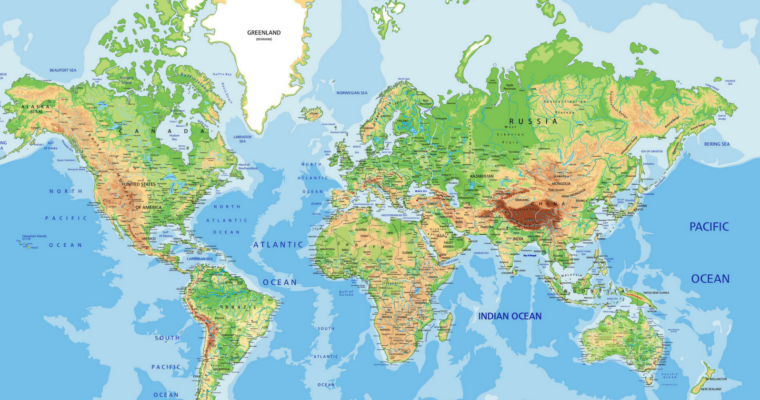

# Analysis:
# It was really fascinating to discover that some factors, such as humidity and max temperatures, tend to have similar outcomes in certain regions.
# The highiest humidity i found is 94. 
# The cloudiness was interesting to me because before performing this analysis I figured it would be mostly cloudy in the regions. The highiest cloudness is 100 in US and NZ. 
# When it came to analyzing the wind speeds I did not imagine the wind speeds would be so low for some areas. The highest speeds I could find during this analysis were at most 14mph. The majority of the world was experiencing anywhere between 1-10mph winds 

In [15]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import json
# Import API key
from api_keys import g_key

### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [16]:
cities_df = pd.read_csv("city_data.csv")
cities_df.dropna()
cities_df.head()

,Unnamed: 0,city,lat,lon,temp,humidity,wind,clouds,country,date
0,0,port alfred,-33.5906,26.8910,69.01,90,5.01,29,ZA,1611001858
1,1,bluff,-46.6000,168.3333,51.01,92,1.99,100,NZ,1611001858
2,2,lagunillas,10.1301,-71.2595,84.09,60,7.76,78,VE,1611001858
3,3,maltahohe,-24.8333,16.9833,78.87,26,14.32,60,NaN,1611001859
4,4,albany,42.6001,-73.9662,37.99,67,9.64,100,US,1611001805


### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [17]:
# Configure gmaps with API key
gmaps.configure(api_key=g_key)

# Store 'Lat' and 'Lng' into  locations
locations = cities_df[["lat", "lon"]]
humidity = cities_df["humidity"].astype(float)

In [18]:
# Plot Heatmap
fig = gmaps.figure(center = [0,0] ,zoom_level = 2)

#Create and add heat layer 
heat_layer = gmaps.heatmap_layer(locations, weights=humidity,
                               dissipating=False, max_intensity=100,
                               point_radius = 4)
fig.add_layer(heat_layer)
#Display figure
fig

Figure(layout=FigureLayout(height='420px'))

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [19]:
weather_file=cities_df.loc[(cities_df['temp']>=70)&(cities_df['temp']<=80)]
wind_file=weather_file.loc[(weather_file['wind']<=10)]
ideal_weather=wind_file.loc[(wind_file['clouds']==0)]
ideal_weather.dropna
ideal_weather.head()

,Unnamed: 0,city,lat,lon,temp,humidity,wind,clouds,country,date
60,60,nileshwar,12.2500,75.1000,75.83,78,4.90,0,IN,1611001866
76,76,pisco,-13.7000,-76.2167,73.00,78,9.22,0,PE,1611001739
96,96,luanda,-8.8368,13.2343,78.80,78,9.22,0,AO,1611001649
99,99,caborca,30.5838,-111.1010,75.99,16,1.01,0,MX,1611001872
173,173,lima,-12.0432,-77.0282,77.00,65,5.75,0,PE,1611001800


### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [20]:
hotel_df = ideal_weather.reset_index(drop=True)
hotel_df["Hotel Name"] = ""
hotel_df

,Unnamed: 0,city,lat,lon,temp,humidity,wind,clouds,country,date,Hotel Name
0,60,nileshwar,12.2500,75.1000,75.83,78,4.90,0,IN,1611001866,
1,76,pisco,-13.7000,-76.2167,73.00,78,9.22,0,PE,1611001739,
2,96,luanda,-8.8368,13.2343,78.80,78,9.22,0,AO,1611001649,
3,99,caborca,30.5838,-111.1010,75.99,16,1.01,0,MX,1611001872,
4,173,lima,-12.0432,-77.0282,77.00,65,5.75,0,PE,1611001800,
5,286,guerrero negro,27.9769,-114.0611,75.90,22,3.98,0,MX,1611001686,
6,367,dzilam gonzalez,21.2833,-88.9333,75.85,54,8.46,0,MX,1611001910,
7,422,filingue,14.3521,3.3168,74.70,19,8.32,0,NE,1611001918,
8,423,candolim,15.5181,73.7626,77.70,67,3.11,0,IN,1611001918,
9,458,calvinia,-31.4707,19.7760,70.65,44,7.20,0,ZA,1611001924,


In [21]:
# params dictionary to update each iteration
params = {
    "radius": 50000,
    "types": "hotel",
    "keyword": "hotels",
    "key": g_key
}

# Use the lat/lng we recovered to identify hotels
for index, row in hotel_df.iterrows():
    
    # get lat, lng 
    lat = row["lat"]
    lng = row["lon"]
    
    # change location each iteration while leaving original params in place
    params["location"] = f"{lat},{lng}"
    
    # Use the search term: "Hotels" and our lat/lng
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    
    # make request and print url
    hotel_name = requests.get(base_url, params=params)
    
    # convert to json
    hotel_name = hotel_name.json()
    
    # Since some data may be missing we incorporate a try-except to skip any that are missing a data point.
    try:
        hotel_df.loc[index, "Hotel Name"] = hotel_name["results"][0]["name"]
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

Missing field/result... skipping.


In [22]:
hotel_df

,Unnamed: 0,city,lat,lon,temp,humidity,wind,clouds,country,date,Hotel Name
0,60,nileshwar,12.2500,75.1000,75.83,78,4.90,0,IN,1611001866,"Taj Bekal Resort & Spa, Kerala"
1,76,pisco,-13.7000,-76.2167,73.00,78,9.22,0,PE,1611001739,"Hotel Paracas, a Luxury Collection Resort, Par..."
2,96,luanda,-8.8368,13.2343,78.80,78,9.22,0,AO,1611001649,EPIC SANA Luanda
3,99,caborca,30.5838,-111.1010,75.99,16,1.01,0,MX,1611001872,Hotel San José
4,173,lima,-12.0432,-77.0282,77.00,65,5.75,0,PE,1611001800,Selina Miraflores Lima
5,286,guerrero negro,27.9769,-114.0611,75.90,22,3.98,0,MX,1611001686,Hotel TerraSal
6,367,dzilam gonzalez,21.2833,-88.9333,75.85,54,8.46,0,MX,1611001910,"Hacienda San Jose, a Luxury Collection Hotel, ..."
7,422,filingue,14.3521,3.3168,74.70,19,8.32,0,NE,1611001918,
8,423,candolim,15.5181,73.7626,77.70,67,3.11,0,IN,1611001918,SinQ Privé
9,458,calvinia,-31.4707,19.7760,70.65,44,7.20,0,ZA,1611001924,Die Hok Self Catering


In [23]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{city}</dd>
<dt>Country</dt><dd>{country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["lat", "lon"]]

In [24]:
# Add marker layer ontop of heat map
markers = gmaps.marker_layer(locations,
    info_box_content=[f"Hotel loc: {rate}" for rate in hotel_info])

fig.add_layer(markers)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))